# Schätzung von Unsicherheiten mittels Bootstrapping

Wir schauen uns erneut den Datensatz des Behavioral Risk Factor Surveillance System (BRFSS) an, siehe Übung "Einführung in das Thema Daten". Wenn man Zugang zu den Daten einer gesamten Population hat, z.B. Alter, Größe, Gewicht, und Tabakkonsum *aller* Erwachsenen eines Landes, ist es einfach, Fragen wie "Wie viel Prozent der Erwachsenen haben in ihrem Leben mehr als 100 Zigaretten geraucht?"
Man könnte dann auch untersuchen, ob und wie sich dieses Verhalten z.B. bei jungen und alten Erwachsenen unterscheidet. Wenn Sie nur Zugang zu einer Stichprobe der Bevölkerung haben, was häufig der Fall ist, wird die Aufgabe komplizierter. Was ist Ihre beste Schätzung für diesen Anteil der (ehemaligen oder aktuellen) Raucher, wenn Sie nur Daten von einer kleinen Stichprobe von Erwachsenen haben? In einer solchen Situation müssen Sie die Stichprobe nutzen, um Rückschlüsse auf die Grundgesamtheit zu ziehen.

In dieser Übung lernen Sie die Technik des **Bootstrapping** kennen, die es Ihnen erlaubt, Schlüsse über die vorliegenden Daten hinaus zu ziehen.  

## Einleitung

Das Behavioral Risk Factor Surveillance System (BRFSS) ist eine jährliche Telefonumfrage bei 350 000 Personen in den Vereinigten Staaten. Wie der Name schon sagt, dient das BRFSS der Ermittlung von Risikofaktoren in der erwachsenen Bevölkerung und der Meldung neuer Gesundheitstrends. So werden die Befragten beispielsweise nach ihrer Ernährung und ihrer wöchentlichen körperlichen Aktivität, ihrem HIV/AIDS-Status, möglichem Tabakkonsum und nach ihrem Krankenversicherungsschutz gefragt. Die [Website] der BRFSS (http://www.cdc.gov/brfss) enthält eine vollständige Beschreibung der Erhebung, einschließlich der Forschungsfragen, die der Studie zugrunde liegen, und vieler interessanter Ergebnisse, die aus den Daten abgeleitet wurden.

Wir werden uns auf eine Zufallsstichprobe von 20.000 Personen aus der BRFSS-Erhebung aus dem Jahr 2000 konzentrieren. Obwohl dieser Datensatz über 200 Variablen enthält, werden wir mit einer kleinen Teilmenge arbeiten.

Wir beginnen mit dem Einlesen des Datensatzes von 20.000 Beobachtungen aus einer csv-Datei.

In [1]:
import numpy as np
import pandas as pd

cdc = pd.read_csv("Daten/brfss_2000.csv")
cdc

,exerany,hlthplan,smoke100,height,weight,wtdesire,age,gender,genhlth
0,0,1,0,70,175,175,77,m,good
1,0,1,1,64,125,115,33,f,good
2,1,1,1,60,105,105,49,f,good
3,1,1,0,66,132,124,42,f,good
4,0,1,0,61,150,130,55,f,very good
...,...,...,...,...,...,...,...,...,...
19995,1,1,0,66,215,140,23,f,good
19996,0,1,0,73,200,185,35,m,excellent
19997,0,1,0,65,216,150,57,f,poor
19998,1,1,0,67,165,165,81,f,good


Der angezeigte Datensatz "cdc" ist ein Pandas DataFrame, bei dem jede Zeile für einen Fall und jede Spalte für eine Variable steht. Wir werden in den Übungen sehr viel mit DataFrames arbeiten.

Um die Namen der Variablen zu sehen, verwenden Sie "columns.values".

In [2]:
cdc.columns.values

array(['exerany', 'hlthplan', 'smoke100', 'height', 'weight', 'wtdesire',
       'age', 'gender', 'genhlth'], dtype=object)

Dies gibt die Namen `genhlth`, `exerany`, `hlthplan`, `smoke100`, `height`, `weight`, `wtdesire`, `age`, und `gender` zurück. Jede dieser Variablen entspricht einer Frage, die in der Erhebung gestellt wurde. Für die Variable `genhlth` wurden die Befragten beispielsweise gebeten, ihren allgemeinen Gesundheitszustand zu bewerten und entweder mit "ausgezeichnet", "sehr gut", "gut", "mittelmäßig" oder "schlecht" zu antworten. Die Variable `exerany` ("exercise any") gibt an, ob der Befragte im letzten Monat Sport getrieben hat (1) oder nicht (0). Ebenso gibt die Variable `hlthplan` an, ob der Befragte in irgendeiner Form krankenversichert war (1) oder nicht (0). Die Variable `smoke100` gibt an, ob die befragte Person in ihrem Leben mindestens 100 Zigaretten geraucht hat. Die anderen Variablen erfassen die Größe in Zoll (`height`), das Gewicht in Pfund (`weight`) sowie das Wunschgewicht (`wtdesire`), das Alter in Jahren (`age`) und das Geschlecht der Befragten (`gender`).

Wir lassen uns nun den Anteil der Menschen, die in ihrem Leben mindestens 100 Zigaretten geraucht haben, ausgeben:

In [3]:
cdc['smoke100'].value_counts(normalize = True)

0    0.52795
1    0.47205
Name: smoke100, dtype: float64

Der Anteil liegt bei 47.205%. Zur Erinnerung: dieser Wert bezieht sich auf die 20,000 zufällig ausgewählten Personen, die eine zufällige *Stichprobe* der ca. 350,000 befragten Personen darstellen. Diese wiederum sind eine Stichprobe *aller* Erwachsenen in den USA.

Um die Sache zu vereinfachen, treffen wir für den Rest dieser Übung folgende **Annahme**:
> Die 20,000 Datensätze sind die Population, über die wir Aussagen treffen möchten. Wir haben allerdings nur eine kleine Stichprobe (die Datensätze von 100 Personen) dieser 20,000 Datensätze zur Verfügung.

Mit folgendem Befehl wählen wir 100 zufällige Datensätze aus:

In [4]:
cdc100 = cdc.sample(100)
cdc100

,exerany,hlthplan,smoke100,height,weight,wtdesire,age,gender,genhlth
17529,0,1,1,72,180,180,50,m,excellent
12450,1,1,0,62,125,125,88,f,very good
9519,0,1,1,66,230,180,34,m,good
11992,1,1,0,70,215,190,54,m,fair
6502,1,1,0,67,118,125,51,f,excellent
...,...,...,...,...,...,...,...,...,...
18671,1,1,0,65,185,160,39,m,good
17802,1,1,1,71,300,200,42,m,very good
5162,1,1,0,65,165,150,47,f,fair
18285,0,1,0,62,140,130,74,f,very good


Wenn Sie die vorherige Zelle mehrmals hintereinander ausführen, werden Sie feststellen, dass jedes Mal eine andere Menge von 100 Datensätzen ausgewählt wird -- zufällig eben. Dies macht die Vergleichbarkeit von Ergebnissen schwierig, daher übergeben wir den Parameter `random_state`. Dies kann eine beliebige ganze Zahl (z.B. [42](https://de.wikipedia.org/wiki/42_(Antwort))) sein und sorgt dafür, dass bei jedem Ausführen die *gleiche* zufällige Stichprobe ausgewählt wird. Überzeugen Sie sich davon, indem Sie die folgende Zelle mehrfach ausführen. Wir arbeiten ab sofort mit dieser Stichprobe weiter und tun so, als wären das die Daten, die wir kennen und als seien uns die restlichen 19900 Datenpunkte nicht bekannt.

In [5]:
cdc100 = cdc.sample(100, random_state=42)
cdc100

,exerany,hlthplan,smoke100,height,weight,wtdesire,age,gender,genhlth
10650,1,1,0,64,118,118,76,f,excellent
2041,1,1,0,62,165,165,88,m,excellent
8668,0,1,0,73,165,180,26,m,excellent
1114,0,1,1,67,180,160,80,m,fair
13902,0,1,1,71,170,170,64,m,good
...,...,...,...,...,...,...,...,...,...
12673,0,1,0,64,165,165,36,f,very good
15455,0,1,0,62,221,160,37,f,poor
14001,0,1,0,71,200,180,41,m,very good
18621,1,1,1,69,170,160,74,m,poor


Für diese 100 zufälligen Datensätze können wir nun natürlich auch den Anteil der Raucher bestimmen:

In [6]:
cdc100['smoke100'].value_counts(normalize = True)

0    0.51
1    0.49
Name: smoke100, dtype: float64

Wenig überraschend ist der Wert *nicht* 47.205%, allerdings ist er auch nicht allzu weit entfernt. Die Frage, die wir mit Hilfe von Bootstrapping beantworten möchten, ist folgende:
>Wenn in einer Stichprobe von 100 zufällig ausgewählten Personen (z.B.) 49 Raucher sind, was ist dann ein plausibler Wert für den Anteil der Raucher in der Population (hier: 20,000 Personen)?

## Konfidenzintervall
Der Anteil der Raucher in der Stichprobe nennt man eine *Punktschätzung* für den Anteil in der Population. Mit Hilfe von Bootstrapping können wir quantifizieren, für wie zuverlässig wir diese Schätzung halten.

Der Begriff Bootstrapping stammt von der Redewendung "pulling oneself up by one’s bootstraps", was eine Metapher für die Bewältigung einer unmöglichen Aufgabe ohne Hilfe von außen ist. In diesem Fall besteht die unlösbare Aufgabe darin, einen Populationsparameter (den unbekannten Populationsanteil 0.47205) zu schätzen. Wir werden dies nur mit Daten aus der gegebenen Stichprobe erreichen. 

Die Idee, etwas über einen Populationsparameter auszusagen, indem nur Informationen aus einer beobachteten Stichprobe verwendet werden, ist der Kern der statistischen Inferenz und nicht auf Bootstrapping beschränkt.

Im Wesentlichen wird beim Bootstrapping davon ausgegangen, dass es in den Populationen mehr Beobachtungen gibt als in der beobachteten Stichprobe. Wir "rekonstruieren" also die Grundgesamtheit durch erneute Stichprobenziehung aus unserer Stichprobe mit Zurücklegen. Das Bootstrapping-Schema sieht folgendermaßen aus:

**Schritt 1**. Ziehe eine Bootstrap-Stichprobe - eine Zufallsstichprobe, die **mit Zurücklegen** aus der ursprünglichen Stichprobe gezogen wird und den gleichen Umfang wie die ursprüngliche Stichprobe hat.

**Schritt 2**. Berechnung der Bootstrap-Statistik - eine Statistik wie Mittelwert, Median, Anteil, Steigung usw., die anhand der Bootstrap-Stichproben berechnet wird (in der Vorlesung wurde das für den Parameter Anteil gemacht).

**Schritt 3**. Wiederholen Sie die Schritte (1) und (2) viele Male, um eine Bootstrap-Verteilung zu erstellen - eine Verteilung der Bootstrap-Statistiken.

**Schritt 4**. Berechnen Sie die Grenzen des 95%-Konfidenzintervalls als die mittleren 95% der Bootstrap-Verteilung (statt 95% können Sie natürlich auch einen anderen Wert nehmen).

### ✏️ Aufgabe 1
1. Schreiben Sie ein Programm, das das Bootstrapping-Schema für den Anteilswert der Raucher umsetzt. Erzeugen Sie 10,000 Bootstrap Samples, d.h. führen Sie 10,000 Mal die Schritte A und B aus:
    1. Eine zufällige Stichprobe mit Zurücklegen vom Umfang 100 aus dem DataFrame `cdc100` wird gezogen.
    2. Der Anteil der Raucher wird berechnet und zurückgegeben.
    
    Speichern Sie für jedes der 10,000 Bootstrap Samples den Anteil der Raucher. Dies ist ihre Bootstrap-Verteilung.
2. Visualisieren Sie die Bootstrap-Verteilung und beschreiben Sie sie. Was ist eine geeignete Visualisierung?
3. Bestimmen Sie die mittleren 95% der Verteilung. Wie lautet das Konfidenzintervall für den Anteil der Raucher unter den 20,000 Personen der Population? Ist der wahre Wert im Intervall enthalten?
4. Wie ändert sich das Konfidenzintervall, wenn Sie nicht das 95%-Intervall nehmen, sondern das 99%-Intervall? Wie ändert es sich, wenn Sie das 80%-Intervall nehmen? Wie sind die Zahlen (95%, 99%, 80%) zu interpretieren?

In [16]:
n_boot = 10000
samples = []
sample_size = 100
for k in range(n_boot):
    # Schritt 1: Ziehe Stichprobe
    boot_sample = cdc100['smoke100'].sample(sample_size, replace=True)
    # Schritt 2: Berechne Anteil und hänge ihn an die Liste an
    samples.append(boot_sample.value_counts(normalize = True)[1])

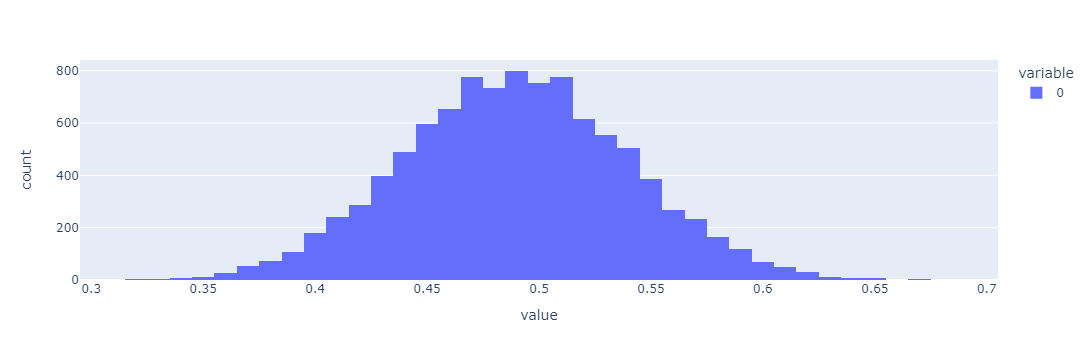

In [17]:
import plotly.express as px
px.histogram( samples )

### ✏️ Aufgabe 2
Wiederholen Sie Aufgabe 1, nur dass Sie stattdessen von einer zufälligen Stichprobe von 1000 Personen ausgehen. Wie verändert sich die Verteilung?

In [104]:
# TO DO


---
Bootstrapping ist ein sehr allgemeines Verfahren und kann zur Quantifizierung von Unsicherheiten anderer Parameter verwendet werden. In Aufgabe 1 und 2 haben wir das für den Anteilswert gemacht. Als nächstes wenden wir die Methodik auf den Mittelwert einer Verteilung an.

Wir schauen uns dazu das Merkmal `height` (Körpergröße in Zoll) an.

### ✏️ Aufgabe 3
Beschreibende Statistik:
- Visualisieren Sie die Verteilung der Körpergröße der Gesamtpopulation in einem Histogramm.
- Visualisieren Sie die Verteilung der Körpergröße der Stichprobe von 100 Personen in einem Histogramm.
- Beschreiben Sie beide Histogramme (mit Worten).
- Berechnen Sie den Mittelwert der Körpergröße der Stichprobe.

In [120]:
# TO DO

### ✏️ Aufgabe 4
Der Mittelwert der Körpergröße der Stichprobe ist eine Schätzung des Mittelwerts der Körpergröße in der Gesamtpopulation (von dem wir annehmen, dass wir ihn nicht kennen). Um die Unsicherheit der dieser Schätzung zu quantifizieren, berechnen Sie als nächstes ein 95%-Konfidenzintervall für den Mittelwert der Körpergröße. Dazu gehe Sie ganz analog zu Aufgabe 1 vor:
1. Erzeugen Sie 10,000 Bootstrap Samples, d.h. führen Sie 10,000 Mal die Schritte 1 und 2 aus:
    1. Eine zufällige Stichprobe mit Zurücklegen vom Umfang 100 aus dem DataFrame `cdc100` wird gezogen.
    2. Der Mittelwert der Körpergröße wird berechnet und zurückgegeben.
    
    Speichern Sie für jedes der 10,000 Bootstrap Samples den Mittelwert der Körpergröße. Dies ist ihre Bootstrap-Verteilung.
2. Visualisieren Sie die Bootstrap-Verteilung und beschreiben Sie sie.
3. Bestimmen Sie die mittleren 95% der Verteilung. Wie lautet das Konfidenzintervall für den Mittelwert der Körpergröße der Population? Ist der wahre Wert im Intervall enthalten?

In [121]:
# TO DO

Eine wichtige Anwendung von schließender Statistik ist die Beantwortung der Frage, ob sich die Mittelwerte zweier Gruppen (Populationen) unterscheiden, wenn von beiden nur eine Stichprobe vorliegt. Es könnte ja schließlich sein, dass man nur zufällig zwei Stichproben erwischt hat, bei denen sich die Mittelwerte stark unterscheiden. Würde man eine größere Stichprobe untersuchen, würden sich die Mittelwerte ja vielleicht annähern.

Eine Möglichkeit, sich dieser Frage zu nähern ist, für beide Gruppen ein Konfidenzintervall zu bestimmen und dann zu überprüfen, ob diese sich überlappen. Die Konfidenzintervalle repräsentieren ja "plausible Werte" für die Populationsparameter. Wenn sich die Intervalle überlappen, so kann man aus der Stichprobe normalerweise nicht schließen, dass beide Mittelwerte voneinander verschieden sind.

In diesem Teil der Übung sollen sie das für die Körpergröße für die Gruppen "männlich" und "weiblich" untersuchen

### ✏️ Aufgabe 5
- Visualisieren Sie die Verteilung der Körpergröße für die beiden Gruppen "m" und "w" in der Stichprobe als Boxplot. Was sehen Sie?
- Berechnen Sie mittels Bootstrapping je ein 99% Konfidenzintervall für den Mittelwert der Körpergröße bei Männern und bei Frauen basierend auf der cdc100 Stichprobe. Was schlussfolgern Sie über den Mittelwert der Körpergröße bei Männern und Frauen in der Gesamtpopulation (20000 Personen)?

In [139]:
# TO DO

---
Um die Vielfältigkeit des Bootstrapping Ansatzes zu illustrieren, sollen abschließend Unsicherheiten von Regressionskoeffizienten quantifiziert werden. Was war das noch gleich?

Mittels Regression und Korrelation können (unter anderem) Zusammenhänge zwischen zwei (metrischen) Merkmalen quantifiziert werden. Wir möchten das hier exemplarisch für die beiden Merkmale Gewicht (`weight`) und Körpergröße (`height`) machen.

### ✏️ Aufgabe 6
- Visualisieren Sie die beiden Merkmale `weight` und `height` in einem Streudiagramm. Beschreiben Sie, was Sie sehen.
- Berechnen Sie den Korrelationskoeffizienten zwischen `weight` und `height`. Was sagt der Wert aus?
- Berechnen Sie die Parameter der Regressionsgeraden $\hat{y}=\alpha+\beta x$ mit folgenden Formeln:
    - $\beta = r_{xy}\frac{\tilde{s}_y}{\tilde{s}_x}$
    - $\alpha = \bar{y} - \beta \bar{x}$
- Interpretieren Sie den Steigungsparameter $\beta$ für den vorliegenden Datensatz.
    
plotly erlaubt es, die Regressionsgerade direkt im Plot zu visualisieren. Dafür muss das Modul `statsmodels` installiert sein (in der Anaconda Konsole `pip install statsmodels` eingeben). Die einfache Regressionsgerade wird über das Argument `trendline="ols"` aktiviert (ols steht für ordinary least squares).

In [ ]:
# TO DO


Zurück zum Steigungsparameter $\beta$: Da dieser nur auf Basis der Stichprobe berechnet wurde, ist er nur eine Schätzung für den Wert $\beta$, den man erhalten würde, wenn man die Regressionsgerade auf der ganzen Population berechnen würde. Jede Schätzung unterliegt einer Unsicherheit. Die Unsicherheit dieser Schätzung quantifizieren wir -- sie ahnen es -- mit Hilfe von Bootstrapping!

### ✏️ Aufgabe 7
Berechnen Sie ein 95%-Konfidenzintervall für den Steigungsparameter $\beta$ der Regressionsgeraden von Körpergröße auf Gewicht. Dazu gehe Sie ganz analog zu Aufgabe 1 vor:
1. Erzeugen Sie 10,000 Bootstrap Samples, d.h. führen Sie 10,000 Mal die Schritte 1 und 2 aus:
    1. Eine zufällige Stichprobe mit Zurücklegen vom Umfang 100 aus dem DataFrame `cdc100` wird gezogen.
    2. Steigungsparameter $\beta$ wird berechnet und zurückgegeben.
    
    Speichern Sie für jedes der 10,000 Bootstrap Samples den Steigungsparameter $\beta$. Dies ist ihre Bootstrap-Verteilung.
2. Visualisieren Sie die Bootstrap-Verteilung und beschreiben Sie sie.
3. Bestimmen Sie die mittleren 95% der Verteilung. Wie lautet das Konfidenzintervall für den Steigungsparameter $\beta$? Ist der wahre Wert im Intervall enthalten?

In [141]:
# TO DO